#📌 Extracción

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from IPython.display import Image, display, Markdown
import os

# Crear directorio para guardar imágenes
if not os.path.exists('figures'):
    os.makedirs('figures')

# Configurar estilo de gráficos
# Omitir plt.style.use() y confiar en el estilo predeterminado de Seaborn
sns.set_style('whitegrid')  # Usar un estilo de Seaborn nativo para consistencia
sns.set_palette("muted")

# Configurar pandas para mostrar todas las columnas
pd.set_option('display.max_columns', None)

# --- 1. Carga de datos ---
url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json"
df = pd.read_json(url)
df_flat = pd.json_normalize(df.to_dict(orient='records'), sep='.')
print("Primeras filas del DataFrame original:\n", df_flat.head())

Primeras filas del DataFrame original:
    customerID Churn customer.gender  customer.SeniorCitizen customer.Partner  \
0  0002-ORFBO    No          Female                       0              Yes   
1  0003-MKNFE    No            Male                       0               No   
2  0004-TLHLJ   Yes            Male                       0               No   
3  0011-IGKFF   Yes            Male                       1              Yes   
4  0013-EXCHZ   Yes          Female                       1              Yes   

  customer.Dependents  customer.tenure phone.PhoneService phone.MultipleLines  \
0                 Yes                9                Yes                  No   
1                  No                9                Yes                 Yes   
2                  No                4                Yes                  No   
3                  No               13                Yes                  No   
4                  No                3                Yes                 

#🔧 Transformación

In [25]:
# --- 2. Limpieza de datos ---
# Verifica el tipo de datos

print(df_flat.dtypes)

# Reemplazar valores vacíos por NaN
df_flat = df_flat.replace('', np.nan)

# Verificar valores nulos iniciales
print("\nValores nulos por columna (antes de limpieza):\n", df_flat.isna().sum())

# Convertir columnas numéricas
numeric_cols = ['customer.tenure', 'account.Charges.Monthly', 'account.Charges.Total']
for col in numeric_cols:
    df_flat[col] = pd.to_numeric(df_flat[col], errors='coerce')

#Verificar nuevamente los tipos de datos
print(df_flat.dtypes)


customerID                    object
Churn                         object
customer.gender               object
customer.SeniorCitizen         int64
customer.Partner              object
customer.Dependents           object
customer.tenure                int64
phone.PhoneService            object
phone.MultipleLines           object
internet.InternetService      object
internet.OnlineSecurity       object
internet.OnlineBackup         object
internet.DeviceProtection     object
internet.TechSupport          object
internet.StreamingTV          object
internet.StreamingMovies      object
account.Contract              object
account.PaperlessBilling      object
account.PaymentMethod         object
account.Charges.Monthly      float64
account.Charges.Total         object
dtype: object

Valores nulos por columna (antes de limpieza):
 customerID                     0
Churn                        224
customer.gender                0
customer.SeniorCitizen         0
customer.Partner            

In [26]:
# Verificar duplicados
duplicates = df_flat.duplicated().sum()
print(f"\nNúmero de filas duplicadas: {duplicates}")
duplicate_ids = df_flat['customerID'].duplicated().sum()
print(f"Número de customerID duplicados: {duplicate_ids}")
if duplicate_ids > 0:
    df_flat = df_flat.drop_duplicates(subset='customerID', keep='first')
    print(f"Duplicados en customerID eliminados. Nuevo número de filas: {len(df_flat)}\n")

# Estandarizar categorías
for col in ['phone.MultipleLines', 'internet.OnlineSecurity', 'internet.OnlineBackup',
            'internet.DeviceProtection', 'internet.TechSupport', 'internet.StreamingTV',
            'internet.StreamingMovies']:
    df_flat[col] = df_flat[col].replace({'No phone service': 'No', 'No internet service': 'No'})
# Imputar valores ausentes
if df_flat['Churn'].isna().sum() > 0:
    churn_mode = df_flat['Churn'].mode()[0]
    df_flat['Churn'] = df_flat['Churn'].fillna(churn_mode)
    print(f"\nValores nulos en Churn imputados con la moda: {churn_mode}")

if df_flat['account.Charges.Total'].isna().sum() > 0:
    df_flat['account.Charges.Total'] = df_flat.groupby('customer.tenure')['account.Charges.Total'].transform(
        lambda x: x.fillna(x.median())
    )
    print("\nValores nulos en Charges.Total imputados con la mediana por tenure")

if df_flat['account.Charges.Monthly'].isna().sum() > 0:
    charges_monthly_median = df_flat['account.Charges.Monthly'].median()
    df_flat['account.Charges.Monthly'] = df_flat['account.Charges.Monthly'].fillna(charges_monthly_median)
    print(f"\nValores nulos en Charges.Monthly imputados con la mediana: {charges_monthly_median}")

# Asegurar que tenure sea entero
df_flat['customer.tenure'] = df_flat['customer.tenure'].round().astype('int64')



Número de filas duplicadas: 0
Número de customerID duplicados: 0

Valores nulos en Churn imputados con la moda: No

Valores nulos en Charges.Total imputados con la mediana por tenure


In [27]:
# --- 3. Estandarización y transformación ---
# Renombrar columnas
column_mapping = {
    'customerID': 'ID_Cliente',
    'Churn': 'Abandono',
    'customer.gender': 'Genero',
    'customer.SeniorCitizen': 'Adulto_Mayor',
    'customer.Partner': 'Pareja',
    'customer.Dependents': 'Dependientes',
    'customer.tenure': 'Antiguedad_Meses',
    'phone.PhoneService': 'Servicio_Telefono',
    'phone.MultipleLines': 'Lineas_Multiples',
    'internet.InternetService': 'Servicio_Internet',
    'internet.OnlineSecurity': 'Seguridad_Online',
    'internet.OnlineBackup': 'Respaldo_Online',
    'internet.DeviceProtection': 'Proteccion_Dispositivo',
    'internet.TechSupport': 'Soporte_Tecnico',
    'internet.StreamingTV': 'Streaming_TV',
    'internet.StreamingMovies': 'Streaming_Peliculas',
    'account.Contract': 'Tipo_Contrato',
    'account.PaperlessBilling': 'Facturacion_Sin_Papel',
    'account.PaymentMethod': 'Metodo_Pago',
    'account.Charges.Monthly': 'Cargos_Mensuales',
    'account.Charges.Total': 'Cargos_Totales'
}
df_flat = df_flat.rename(columns=column_mapping)


In [28]:
# Convertir variables categóricas
binary_cols = ['Abandono', 'Pareja', 'Dependientes', 'Servicio_Telefono', 'Facturacion_Sin_Papel',
               'Lineas_Multiples', 'Seguridad_Online', 'Respaldo_Online', 'Proteccion_Dispositivo',
               'Soporte_Tecnico', 'Streaming_TV', 'Streaming_Peliculas']
for col in binary_cols:
    df_flat[col] = df_flat[col].map({'Yes': 1, 'No': 0})

df_flat['Adulto_Mayor'] = df_flat['Adulto_Mayor'].astype(int)
df_flat['Genero'] = df_flat['Genero'].map({'Male': 1, 'Female': 0})
df_flat['Tipo_Contrato'] = df_flat['Tipo_Contrato'].map({'Month-to-month': 0, 'One year': 1, 'Two year': 2})
df_flat['Servicio_Internet'] = df_flat['Servicio_Internet'].map({'No': 0, 'DSL': 1, 'Fiber optic': 2})
df_flat['Metodo_Pago'] = df_flat['Metodo_Pago'].map({
    'Electronic check': 0, 'Mailed check': 1, 'Bank transfer (automatic)': 2, 'Credit card (automatic)': 3
})

# Normalizar variables numéricas
scaler = MinMaxScaler()
numeric_cols = ['Antiguedad_Meses', 'Cargos_Mensuales', 'Cargos_Totales']
df_flat[numeric_cols] = scaler.fit_transform(df_flat[numeric_cols])

# Vista de las datos transformados

print("Primeras filas del DataFrame original:\n", df_flat.head())


Primeras filas del DataFrame original:
    ID_Cliente  Abandono  Genero  Adulto_Mayor  Pareja  Dependientes  \
0  0002-ORFBO         0       0             0       1             1   
1  0003-MKNFE         0       1             0       0             0   
2  0004-TLHLJ         1       1             0       0             0   
3  0011-IGKFF         1       1             1       1             0   
4  0013-EXCHZ         1       0             1       1             0   

   Antiguedad_Meses  Servicio_Telefono  Lineas_Multiples  Servicio_Internet  \
0          0.125000                  1                 0                  1   
1          0.125000                  1                 1                  1   
2          0.055556                  1                 0                  2   
3          0.180556                  1                 0                  2   
4          0.041667                  1                 0                  2   

   Seguridad_Online  Respaldo_Online  Proteccion_Dispositi

#📊 Carga y análisis

In [29]:
# --- 4. Crear Cuentas_Diarias ---
df_flat['Cargos_Mensuales_original'] = scaler.inverse_transform(
    df_flat[['Antiguedad_Meses', 'Cargos_Mensuales', 'Cargos_Totales']
])[:, 1]
df_flat['Cuentas_Diarias'] = df_flat['Cargos_Mensuales_original'] / 30
df_flat['Cuentas_Diarias'] = df_flat['Cuentas_Diarias'].round(2)
df_flat = df_flat.drop(columns=['Cargos_Mensuales_original'])

# --- 5. Crear Cantidad_Servicios ---
service_cols = ['Lineas_Multiples', 'Seguridad_Online', 'Respaldo_Online', 'Proteccion_Dispositivo',
                'Soporte_Tecnico', 'Streaming_TV', 'Streaming_Peliculas']
df_flat['Cantidad_Servicios'] = df_flat[service_cols].sum(axis=1)

# --- 6. Análisis descriptivo ---
# Variables numéricas
numeric_cols = ['Antiguedad_Meses', 'Cargos_Mensuales', 'Cargos_Totales', 'Cuentas_Diarias', 'Cantidad_Servicios']
print("\nEstadísticas descriptivas de variables numéricas:")
desc_numeric = df_flat[numeric_cols].describe().round(4)
print(desc_numeric)

# Estadísticas numéricas por Abandono
print("\nEstadísticas numéricas por Abandono:")
desc_by_churn = df_flat.groupby('Abandono')[numeric_cols].agg(['mean', 'median', 'std']).round(4)
print(desc_by_churn)

# Variables categóricas
categorical_cols = [
    'Abandono', 'Genero', 'Adulto_Mayor', 'Pareja', 'Dependientes', 'Servicio_Telefono',
    'Lineas_Multiples', 'Servicio_Internet', 'Seguridad_Online', 'Respaldo_Online',
    'Proteccion_Dispositivo', 'Soporte_Tecnico', 'Streaming_TV', 'Streaming_Peliculas',
    'Tipo_Contrato', 'Facturacion_Sin_Papel', 'Metodo_Pago'
]
print("\nFrecuencias de variables categóricas:")
freq_tables = {}
for col in categorical_cols:
    print(f"\n{col}:")
    freq_table = df_flat[col].value_counts(dropna=False)
    freq_table_rel = df_flat[col].value_counts(normalize=True, dropna=False).round(4) * 100
    freq_tables[col] = pd.concat([freq_table, freq_table_rel], axis=1, keys=['Frecuencia', 'Porcentaje (%)'])
    print(freq_tables[col])



Estadísticas descriptivas de variables numéricas:
       Antiguedad_Meses  Cargos_Mensuales  Cargos_Totales  Cuentas_Diarias  \
count         7267.0000         7267.0000       7256.0000        7267.0000   
mean             0.4493            0.4624          0.2610           2.1573   
std              0.3413            0.2998          0.2618           1.0044   
min              0.0000            0.0000          0.0000           0.6100   
25%              0.1250            0.1709          0.0440           1.1800   
50%              0.4028            0.5179          0.1583           2.3400   
75%              0.7639            0.7127          0.4346           2.9950   
max              1.0000            1.0000          1.0000           3.9600   

       Cantidad_Servicios  
count           7267.0000  
mean               2.4560  
std                2.0466  
min                0.0000  
25%                1.0000  
50%                2.0000  
75%                4.0000  
max                7.0

In [30]:
# --- 7. Distribución de Abandono ---
print("\nDistribución general de Abandono:")
freq_abandono = df_flat['Abandono'].value_counts(normalize=True).round(4) * 100
print(pd.DataFrame({
    'Frecuencia': df_flat['Abandono'].value_counts(),
    'Porcentaje (%)': freq_abandono
}))

# --- 8. Distribución de Abandono por categóricas ---
print("\nTablas de contingencia (porcentaje de Abandono por categoría):")
contingency_tables = {}
for col in categorical_cols:
    if col != 'Abandono':
        print(f"\n{col} vs. Abandono:")
        contingency = pd.crosstab(df_flat[col], df_flat['Abandono'], normalize='index').round(4) * 100
        contingency.columns = ['No Abandono (%)', 'Abandono (%)']
        print(contingency)
        contingency_tables[col] = contingency

# --- 9. Correlación entre variables ---
corr_cols = numeric_cols + ['Abandono', 'Genero', 'Adulto_Mayor', 'Pareja', 'Dependientes',
                            'Servicio_Telefono', 'Servicio_Internet', 'Tipo_Contrato',
                            'Facturacion_Sin_Papel', 'Metodo_Pago']
correlation_matrix = df_flat[corr_cols].corr()
print("\nCorrelaciones con Abandono:")
print(correlation_matrix['Abandono'].sort_values(ascending=False).round(4))

# --- 10. Visualizaciones ---
# Gráfico 1: Distribución general de Abandono
plt.figure(figsize=(8, 6))
sns.countplot(x='Abandono', data=df_flat)
plt.title('Distribución de Abandono')
plt.xlabel('Abandono (0 = No, 1 = Sí)')
plt.ylabel('Cantidad de Clientes')
plt.xticks(ticks=[0, 1], labels=['No', 'Sí'])
plt.savefig('figures/abandono_distribucion.png')
plt.close()



Distribución general de Abandono:
          Frecuencia  Porcentaje (%)
Abandono                            
0               5398           74.28
1               1869           25.72

Tablas de contingencia (porcentaje de Abandono por categoría):

Genero vs. Abandono:
        No Abandono (%)  Abandono (%)
Genero                               
0                 73.86         26.14
1                 74.69         25.31

Adulto_Mayor vs. Abandono:
              No Abandono (%)  Abandono (%)
Adulto_Mayor                               
0                       77.11         22.89
1                       59.73         40.27

Pareja vs. Abandono:
        No Abandono (%)  Abandono (%)
Pareja                               
0                 67.99         32.01
1                 80.98         19.02

Dependientes vs. Abandono:
              No Abandono (%)  Abandono (%)
Dependientes                               
0                       69.66         30.34
1                       85.05         14.

In [32]:
# Gráficos de barras apiladas para categóricas
for col in categorical_cols:
    if col != 'Abandono':
        plt.figure(figsize=(10, 6))
        prop_table = pd.crosstab(df_flat[col], df_flat['Abandono'], normalize='index') * 100
        prop_table.plot(kind='bar', stacked=True, ax=plt.gca(), color=['#1f77b4', '#ff7f0e'])
        plt.title(f'Proporción de Abandono por {col}')
        plt.xlabel(col)
        plt.ylabel('Porcentaje (%)')
        plt.legend(['No Abandono', 'Abandono'], title='Abandono')
        if col == 'Genero':
            plt.xticks(ticks=[0, 1], labels=['Femenino', 'Masculino'])
        elif col in ['Adulto_Mayor', 'Pareja', 'Dependientes', 'Servicio_Telefono', 'Lineas_Multiples',
                     'Seguridad_Online', 'Respaldo_Online', 'Proteccion_Dispositivo', 'Soporte_Tecnico',
                     'Streaming_TV', 'Streaming_Peliculas', 'Facturacion_Sin_Papel']:
            plt.xticks(ticks=[0, 1], labels=['No', 'Sí'])
        elif col == 'Tipo_Contrato':
            plt.xticks(ticks=[0, 1, 2], labels=['Mes a Mes', '1 Año', '2 Años'])
        elif col == 'Servicio_Internet':
            plt.xticks(ticks=[0, 1, 2], labels=['No', 'DSL', 'Fibra Óptica'])
        elif col == 'Metodo_Pago':
            plt.xticks(ticks=[0, 1, 2, 3], labels=['Cheque Electrónico', 'Cheque por Correo', 'Transferencia', 'Tarjeta'])
        plt.tight_layout()
        plt.savefig(f'figures/abandono_por_{col.lower().replace(" ", "_")}.png')
        plt.close()

# Histogramas y boxplots para numéricas
for col in numeric_cols:
    # Boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Abandono', y=col, data=df_flat)
    plt.title(f'Distribución de {col} por Abandono')
    plt.xlabel('Abandono (0 = No, 1 = Sí)')
    plt.ylabel(col)
    plt.xticks(ticks=[0, 1], labels=['No', 'Sí'])
    plt.savefig(f'figures/boxplot_{col.lower().replace(" ", "_")}.png')
    plt.close()
    # Histograma
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df_flat, x=col, hue='Abandono', bins=30, kde=True, multiple='stack')
    plt.title(f'Distribución de {col} por Abandono')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.legend(labels=['No Abandono', 'Abandono'])
    plt.savefig(f'figures/hist_{col.lower().replace(" ", "_")}.png')
    plt.close()

# Matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Matriz de Correlaciones')
plt.savefig('figures/correlation_matrix.png')
plt.close()

# Gráficos de dispersión
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Cuentas_Diarias', y='Abandono', data=df_flat, alpha=0.5)
plt.title('Cuentas_Diarias vs. Abandono')
plt.xlabel('Cargos Diarios ($)')
plt.ylabel('Abandono (0 = No, 1 = Sí)')
plt.savefig('figures/scatter_cuentas_diarias.png')
plt.close()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Cantidad_Servicios', y='Abandono', data=df_flat, alpha=0.5)
plt.title('Cantidad_Servicios vs. Abandono')
plt.xlabel('Número de Servicios')
plt.ylabel('Abandono (0 = No, 1 = Sí)')
plt.savefig('figures/scatter_cantidad_servicios.png')
plt.close()

# --- 11. Guardar resultados ---
df_flat.to_csv('TelecomX_Data_cleaned_transformed.csv', index=False)
desc_numeric.to_csv('TelecomX_numeric_descriptive.csv')
desc_by_churn.to_csv('TelecomX_numeric_by_churn.csv')
correlation_matrix.to_csv('TelecomX_correlation_matrix.csv')
for col, table in freq_tables.items():
    table.to_csv(f'TelecomX_freq_{col}.csv')
for col, table in contingency_tables.items():
    table.to_csv(f'TelecomX_contingency_{col}.csv')
print("\nArchivos guardados:")
print("- DataFrame transformado: 'TelecomX_Data_cleaned_transformed.csv'")
print("- Estadísticas numéricas: 'TelecomX_numeric_descriptive.csv'")
print("- Estadísticas por Abandono: 'TelecomX_numeric_by_churn.csv'")
print("- Matriz de correlación: 'TelecomX_correlation_matrix.csv'")
print("- Frecuencias categóricas: 'TelecomX_freq_*.csv'")
print("- Tablas de contingencia: 'TelecomX_contingency_*.csv'")


Archivos guardados:
- DataFrame transformado: 'TelecomX_Data_cleaned_transformed.csv'
- Estadísticas numéricas: 'TelecomX_numeric_descriptive.csv'
- Estadísticas por Abandono: 'TelecomX_numeric_by_churn.csv'
- Matriz de correlación: 'TelecomX_correlation_matrix.csv'
- Frecuencias categóricas: 'TelecomX_freq_*.csv'
- Tablas de contingencia: 'TelecomX_contingency_*.csv'


#📄Informe final


# Informe de Análisis de Churn de Clientes - Telecom X

## Introducción
El objetivo de este análisis es identificar los factores que contribuyen a la 
**evasión de clientes (churn)** en Telecom X, utilizando un conjunto de datos de clientes.
 La evasión, o abandono, representa la pérdida de clientes que cancelan sus servicios, 
 lo que impacta directamente los ingresos y la sostenibilidad del negocio. Este informe 
 analiza patrones en variables numéricas (como antigüedad, cargos mensuales y totales) y 
 categóricas (como tipo de contrato, método de pago y servicios contratados) para proponer 
 estrategias que reduzcan la tasa de churn.

El análisis incluye limpieza de datos, creación de variables derivadas, análisis exploratorio
 con visualizaciones, y correlaciones para entender las relaciones entre variables. 
 Los insights derivados guiarán recomendaciones estratégicas para mejorar la retención de clientes.

## Limpieza y Tratamiento de Datos
Los datos fueron procesados en las siguientes etapas:

1. **Carga de datos**: Se importó un archivo JSON desde una URL pública y se aplanaron las columnas 
anidadas usando `pd.json_normalize`.
2. **Manejo de valores nulos**:
   - Los valores vacíos (`""`) fueron reemplazados por `NaN`.
   - La variable `Abandono` (`Churn`) se imputó con la moda.
   - `Cargos_Totales` (`Charges.Total`) se imputó con la mediana agrupada por `Antiguedad_Meses` (`tenure`).
   - `Cargos_Mensuales` (`Charges.Monthly`) se imputó con la mediana general.
3. **Eliminación de duplicados**: Se verificaron y eliminaron duplicados basados en `ID_Cliente` (`customerID`).
4. **Estandarización de categorías**:
   - En columnas de servicios, `No phone service` y `No internet service` se reemplazaron por `No`.
   - `Antiguedad_Meses` se convirtió a tipo entero.
5. **Transformación de datos**:
   - Las columnas se renombraron a español (por ejemplo, `Churn` → `Abandono`, `tenure` → `Antiguedad_Meses`).
   - Las variables categóricas se convirtieron a binarias (`Yes`/`No` → 1/0) u ordinales 
   (por ejemplo, `Tipo_Contrato`: mes a mes = 0, 1 año = 1, 2 años = 2).
   - Las variables numéricas (`Antiguedad_Meses`, `Cargos_Mensuales`, `Cargos_Totales`)
    se normalizaron al rango [0, 1].
6. **Creación de variables derivadas**:
   - `Cuentas_Diarias`: Calculada como `Cargos_Mensuales` dividido por 30, redondeado a 2 decimales.
   - `Cantidad_Servicios`: Suma de servicios contratados (por ejemplo, `Lineas_Multiples`, 
   `Seguridad_Online`, `Soporte_Tecnico`), rango de 0 a 7.

El resultado es un conjunto de datos limpio, estandarizado y enriquecido, listo para el análisis exploratorio.

## Análisis Exploratorio de Datos
El análisis exploratorio se dividió en varias etapas para identificar patrones relacionados con el churn:

### 1. Análisis Descriptivo
Se calcularon estadísticas descriptivas para variables numéricas y frecuencias para categóricas:
- **Numéricas**: `Antiguedad_Meses`, `Cargos_Mensuales`, `Cargos_Totales`, `Cuentas_Diarias`, `Cantidad_Servicios`.
- **Categóricas**: `Abandono`, `Genero`, `Adulto_Mayor`, `Pareja`, `Dependientes`, `Servicio_Telefono`, 
`Lineas_Multiples`, `Servicio_Internet`, `Seguridad_Online`, `Respaldo_Online`, `Proteccion_Dispositivo`, 
`Soporte_Tecnico`, `Streaming_TV`, `Streaming_Peliculas`, `Tipo_Contrato`, `Facturacion_Sin_Papel`, `Metodo_Pago`.

### 2. Distribución de Abandono
Se analizó la proporción general de clientes que abandonaron (`Abandono = 1`) frente a los que permanecieron 
(`Abandono = 0`), como se muestra en la Figura 1.


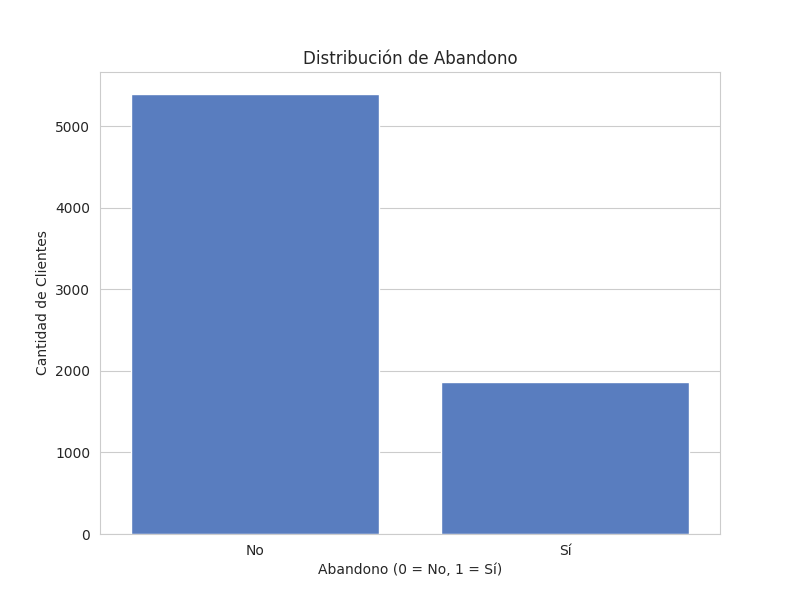



### 3. Abandono por Variables Categóricas
Se examinó cómo `Abandono` varía según variables categóricas, utilizando tablas de contingencia y gráficos
 de barras apiladas (Figuras 2-17). Las variables analizadas incluyen `Genero`, `Tipo_Contrato`, 
 `Servicio_Internet`, `Metodo_Pago`, y servicios adicionales como `Seguridad_Online` y `Soporte_Tecnico`.
 

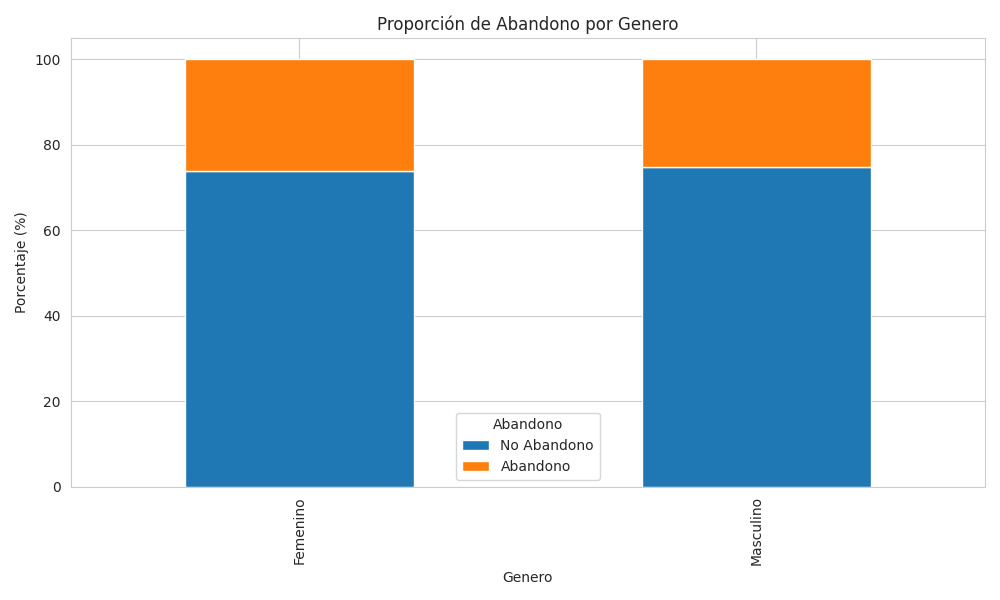

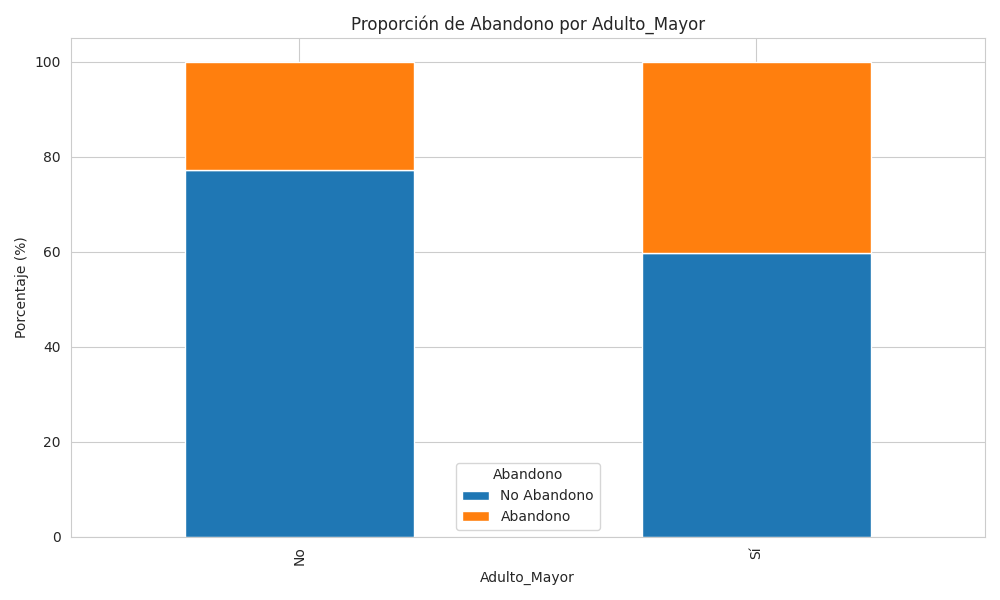

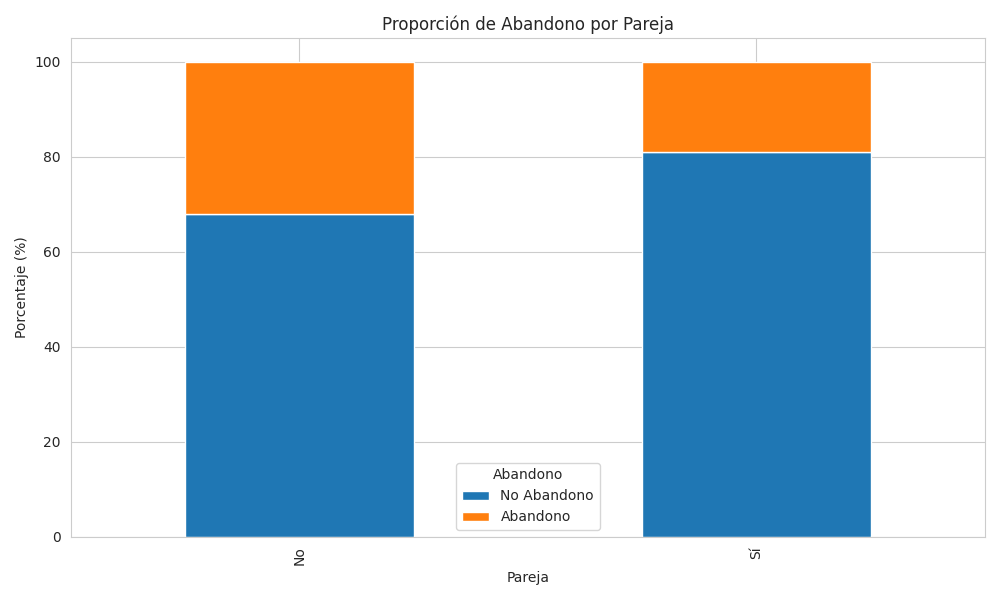

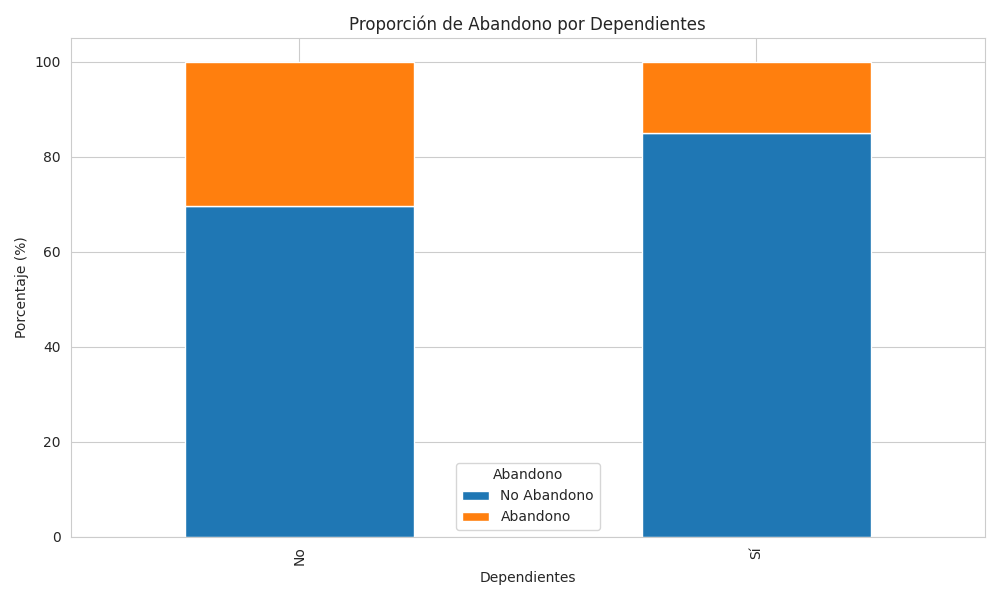

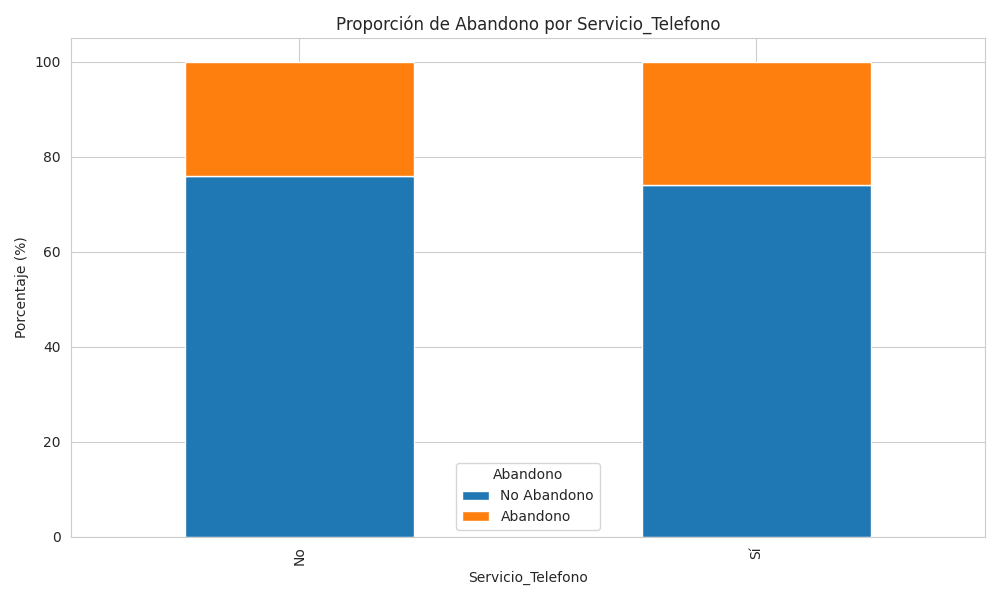

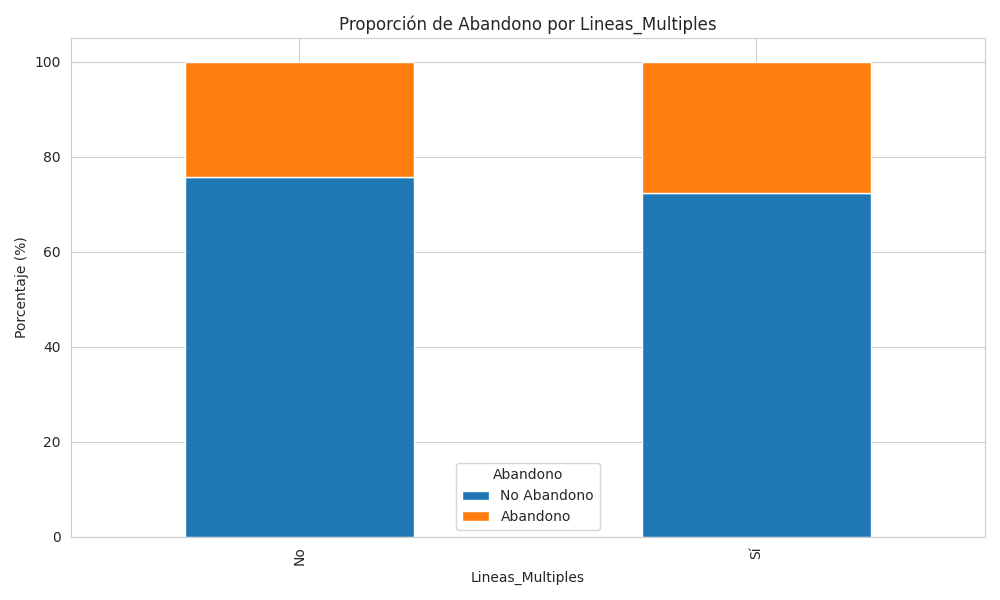

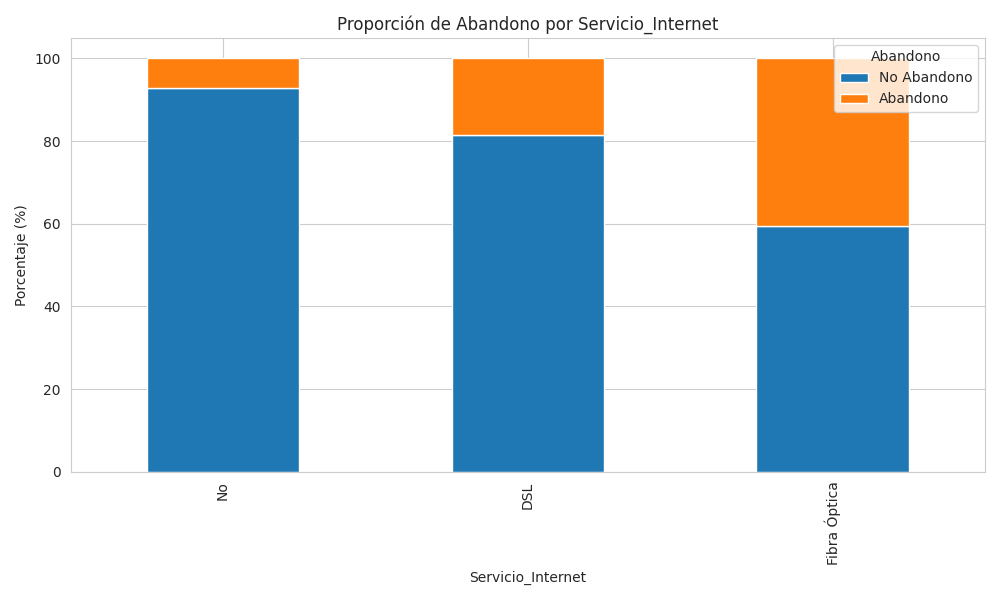

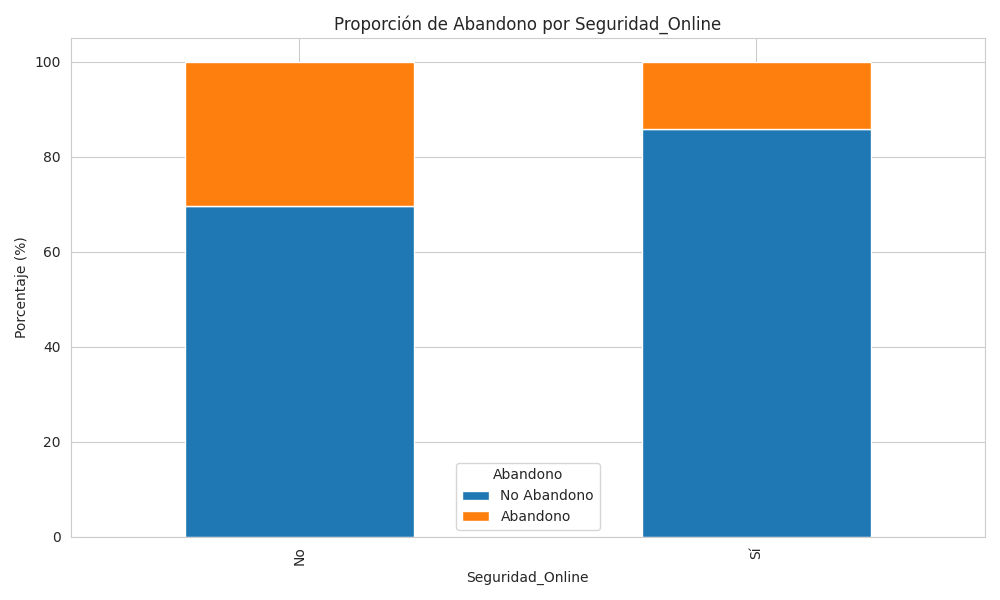

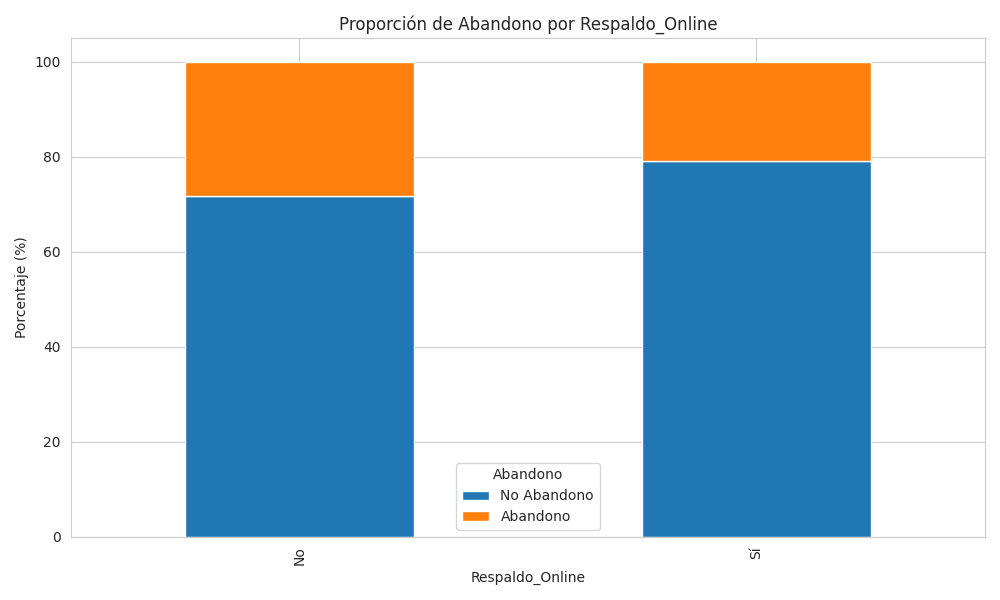

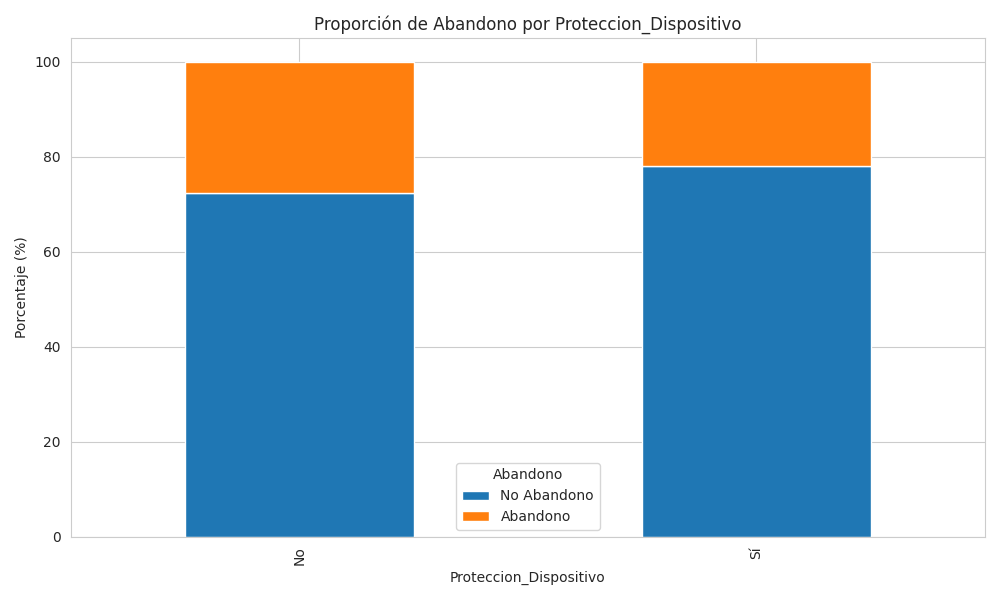

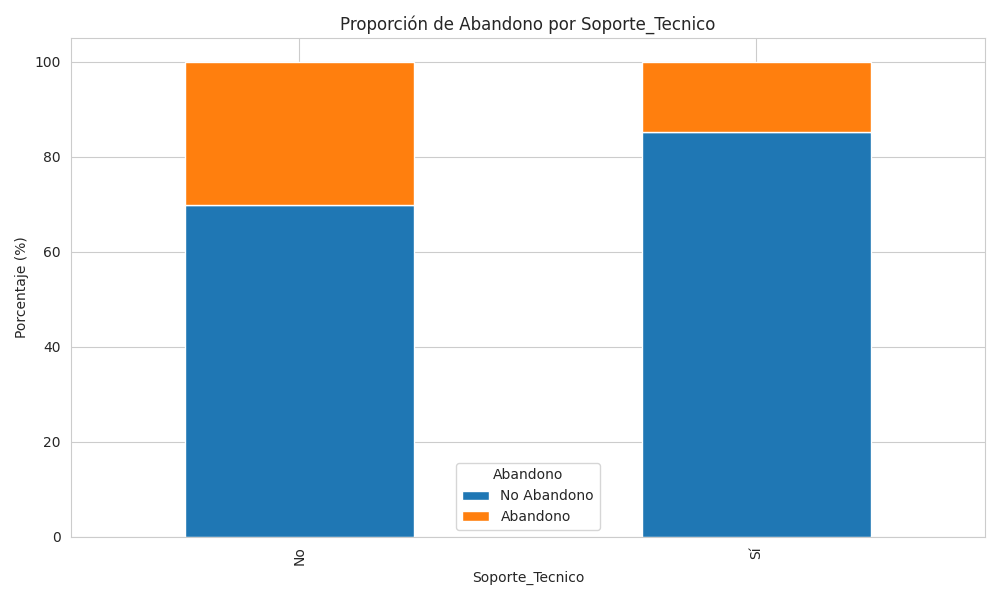

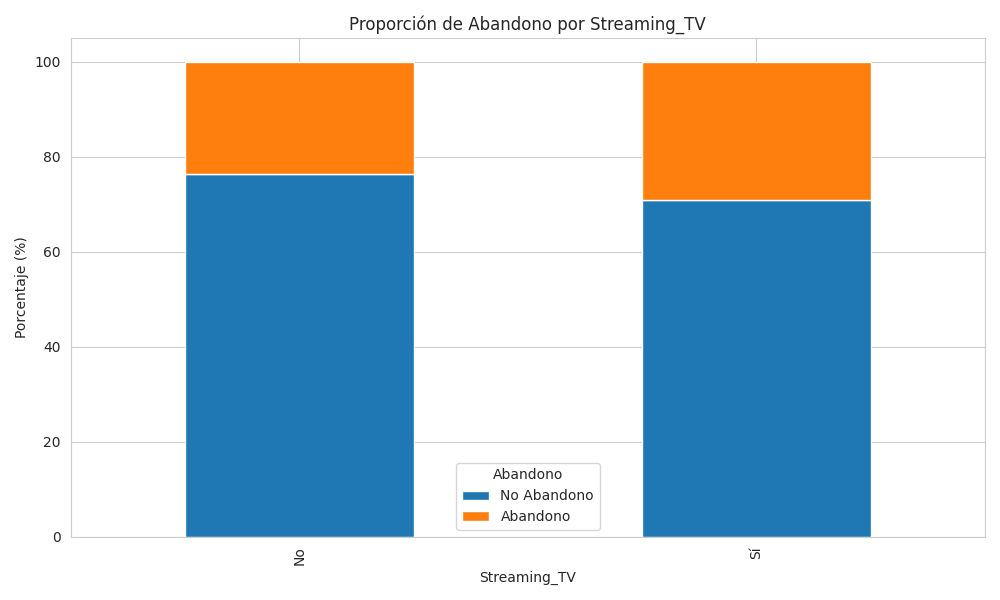

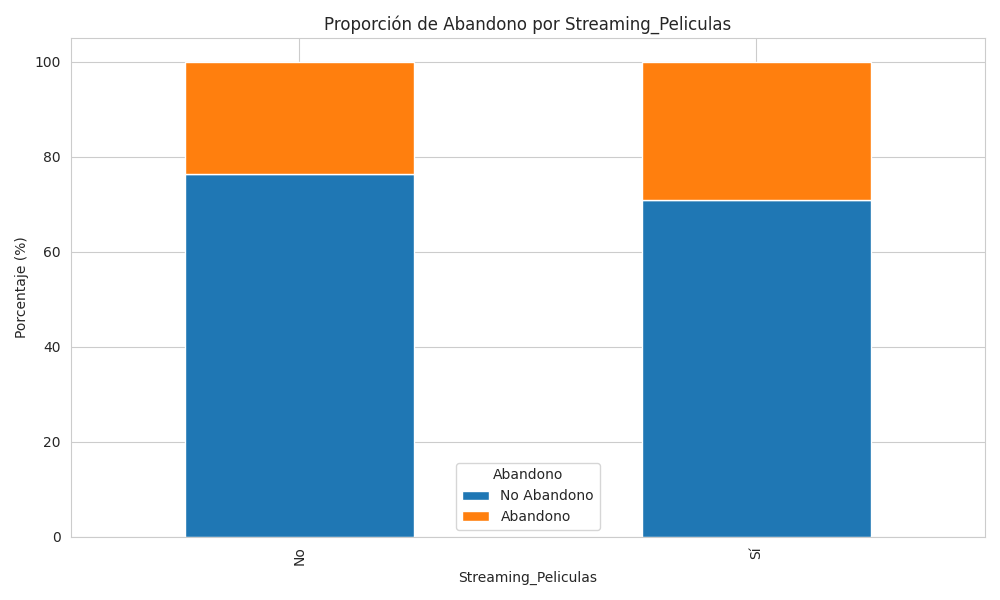

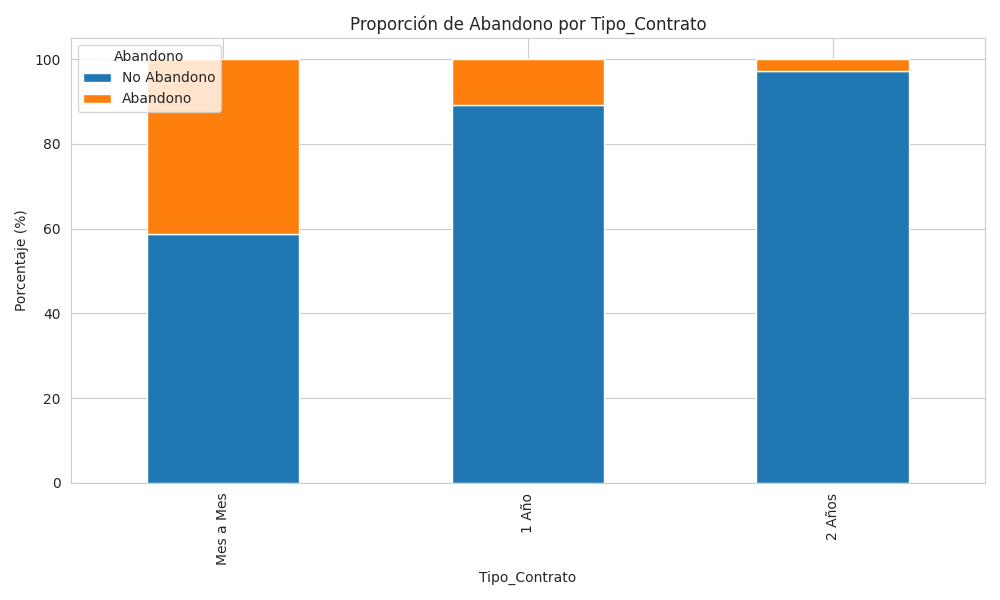

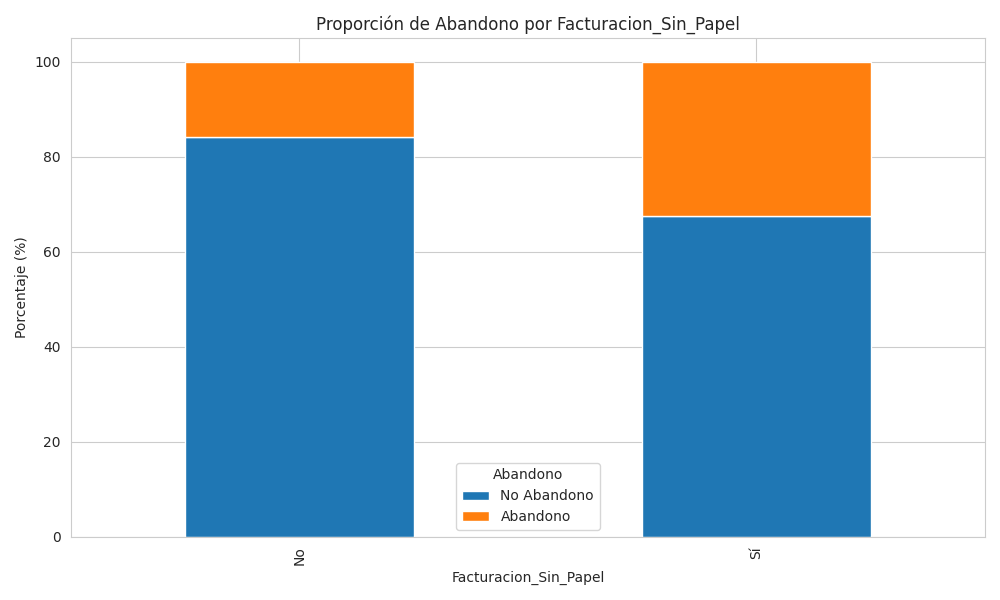

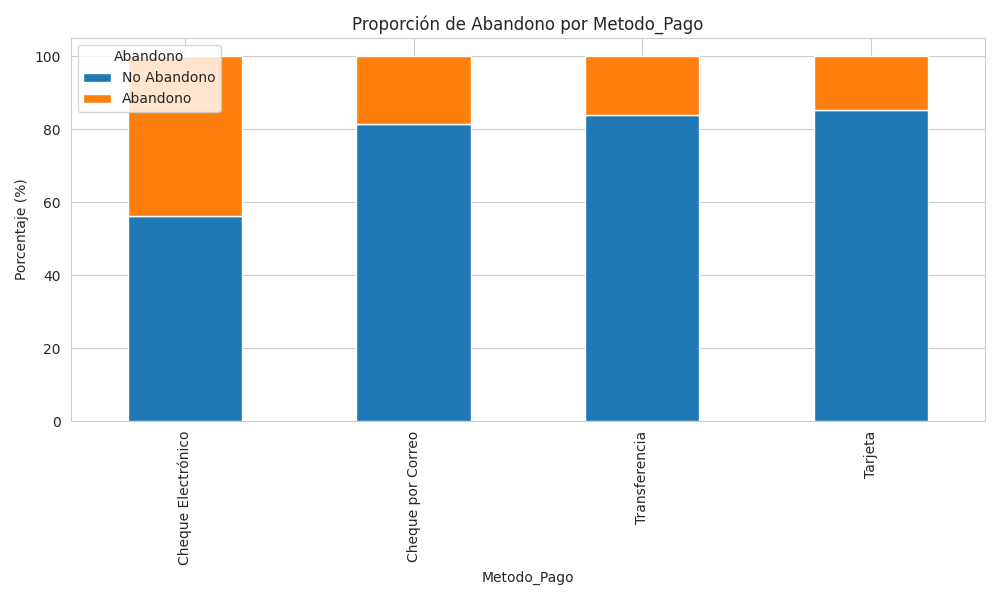


### 4. Distribución de Variables Numéricas por Abandono
Se compararon las distribuciones de las variables numéricas entre clientes con y sin abandono, 
utilizando estadísticas descriptivas y visualizaciones:
- **Boxplots** (Figuras 18-22): Muestran los rangos y valores atípicos de cada variable numérica según 
`Abandono`.


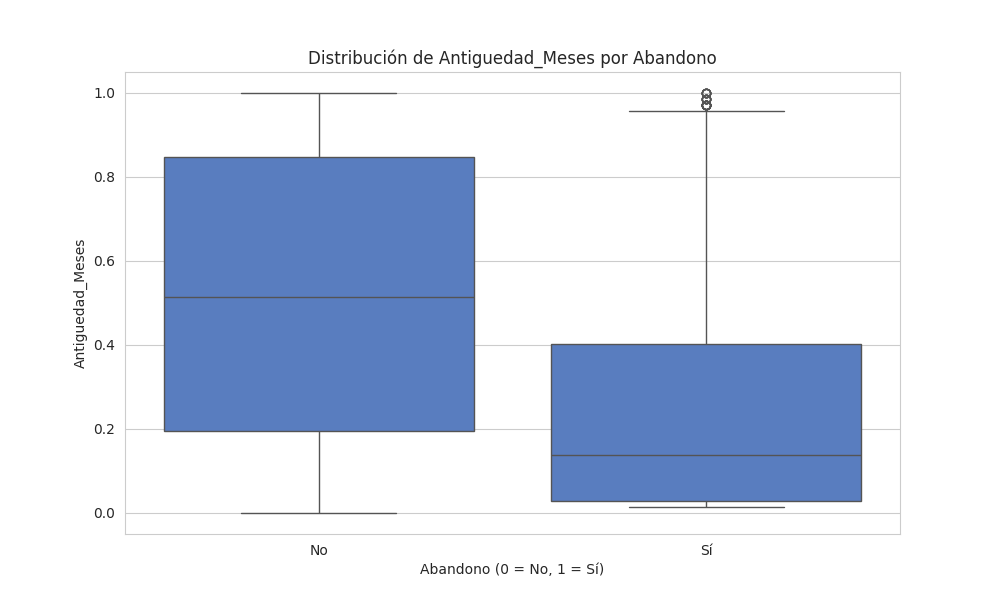

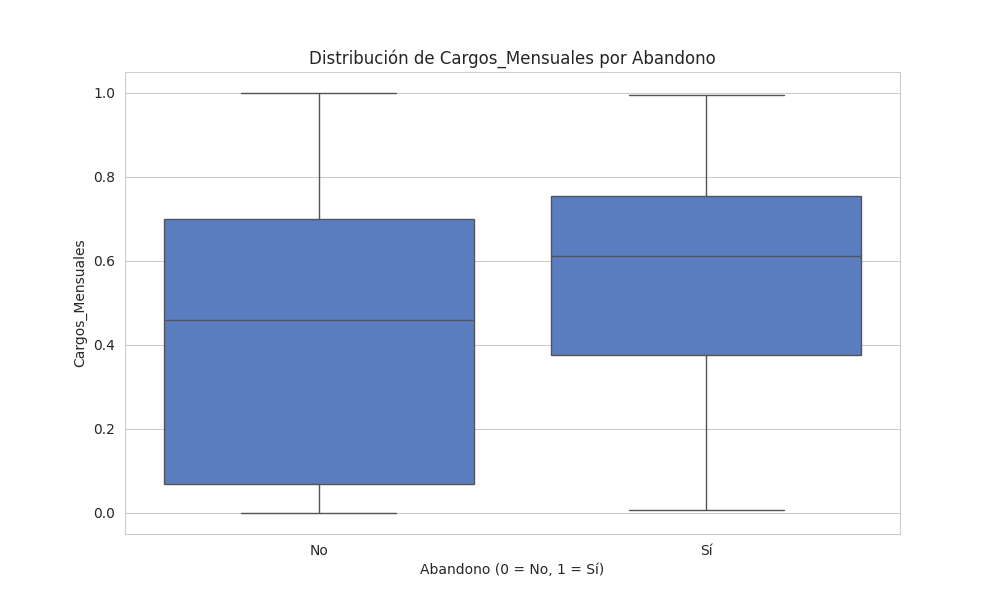

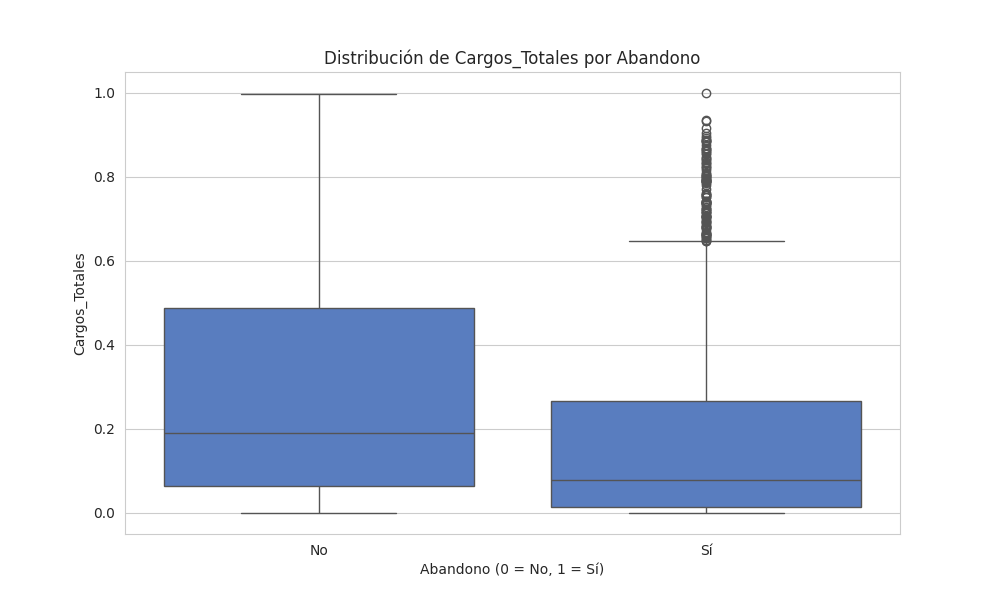

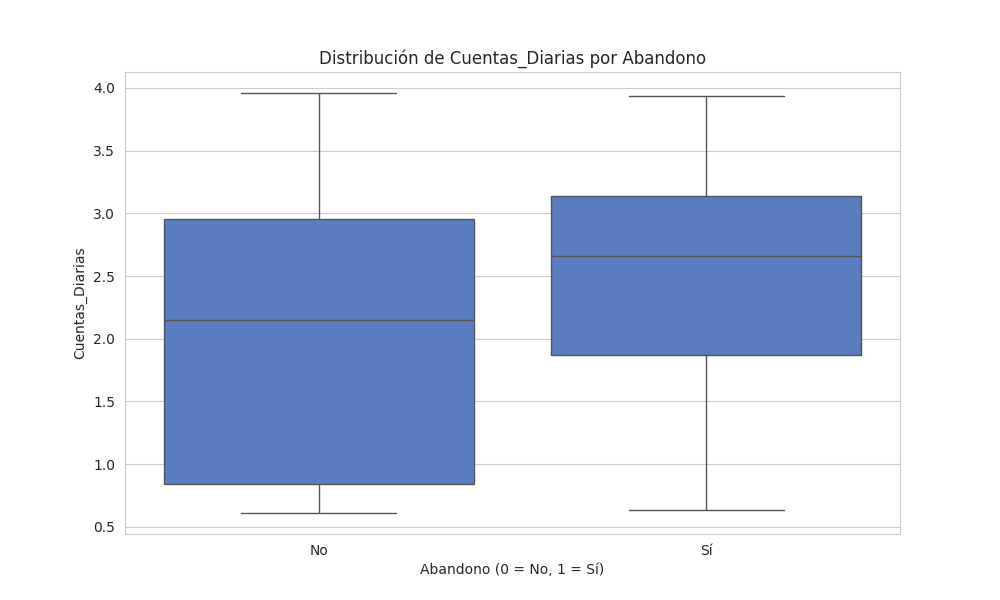

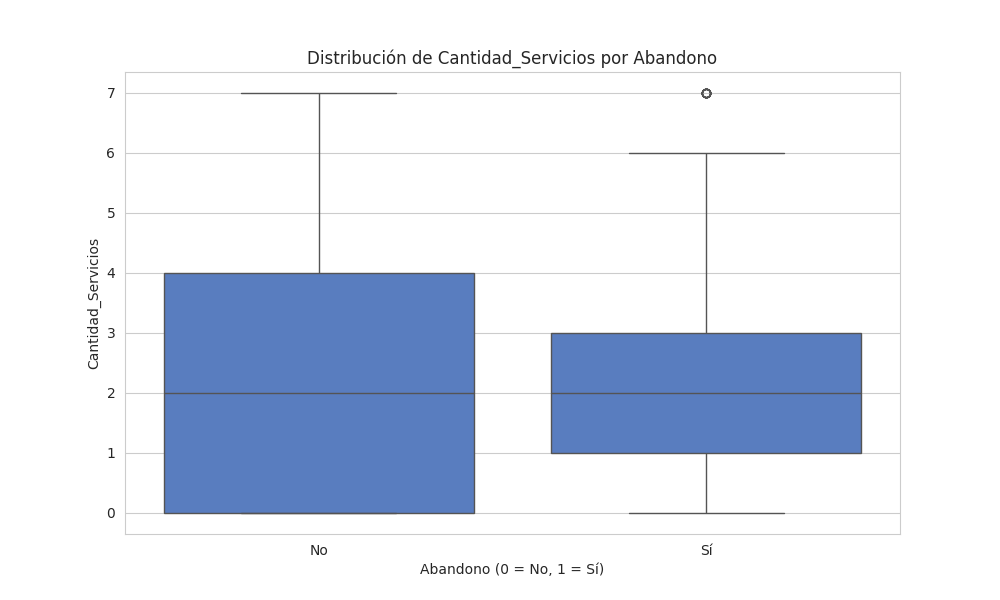


- **Histogramas** (Figuras 23-27): Ilustran la distribución de frecuencia de las variables numéricas, 
diferenciadas por `Abandono`.


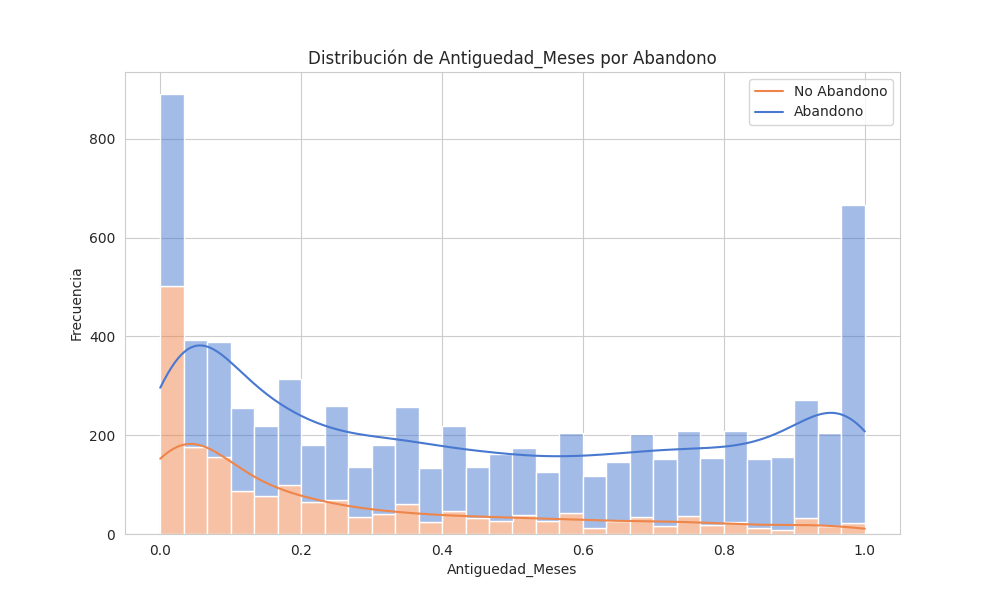

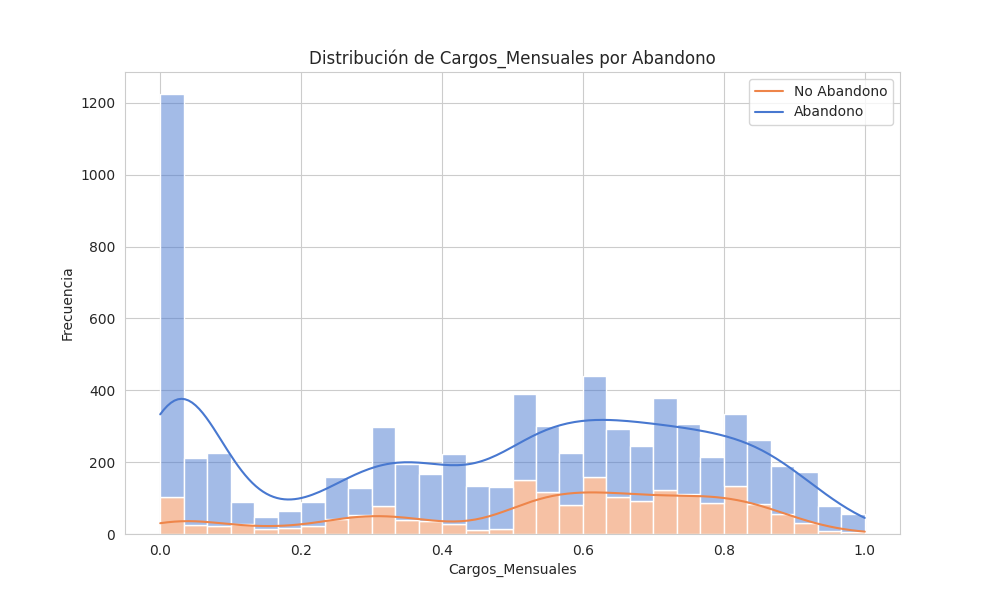

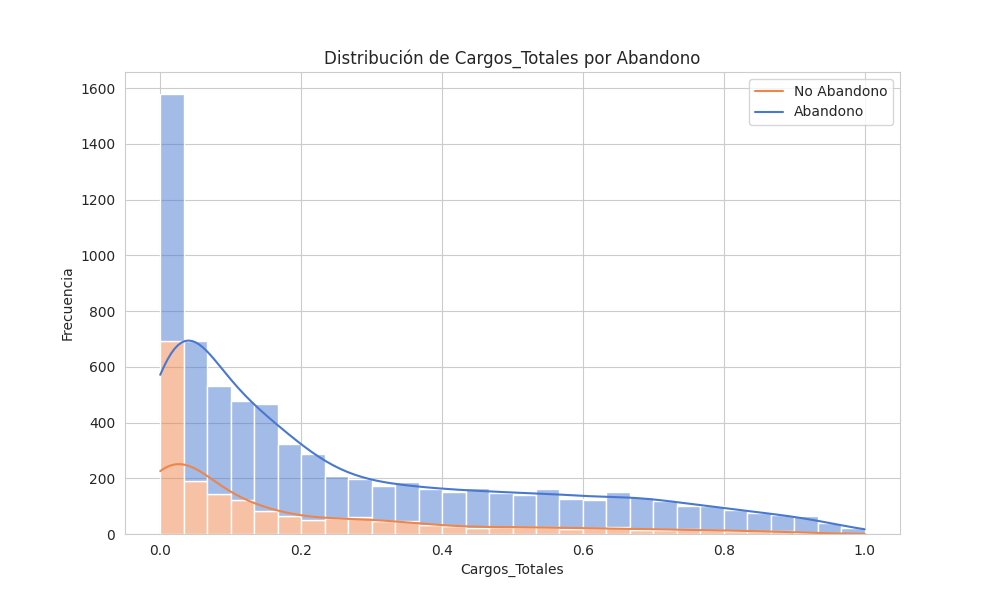

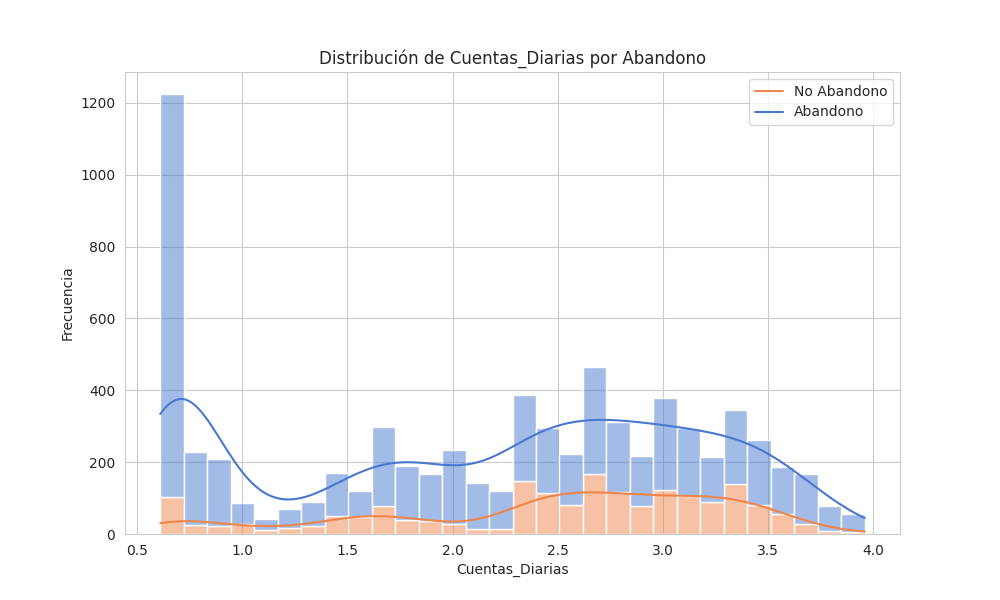

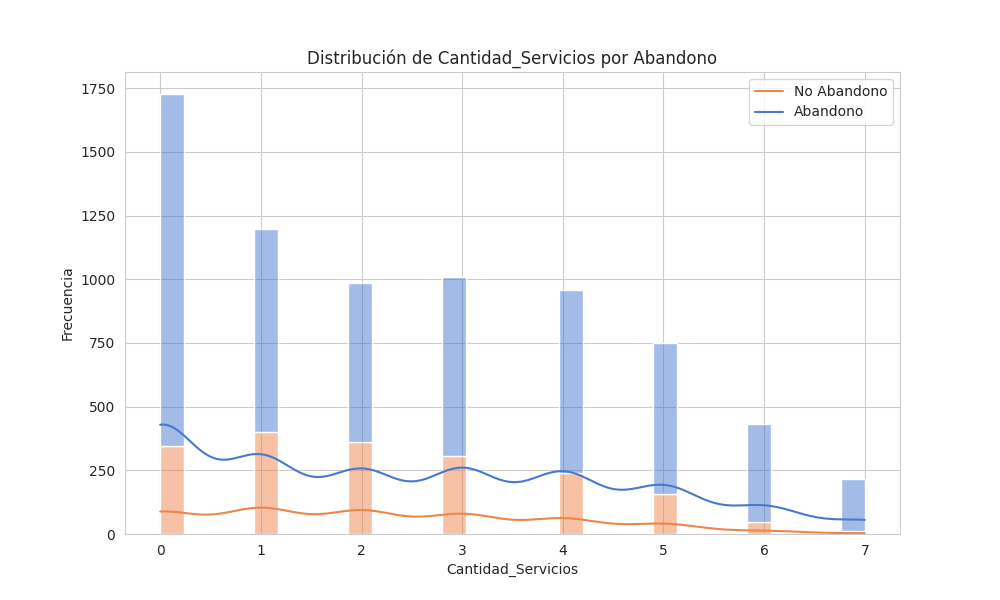


### 5. Análisis de Correlación
Se calculó la matriz de correlación para todas las variables numéricas y categóricas codificadas,
 con un enfoque en las relaciones entre `Abandono`, `Cuentas_Diarias`, y `Cantidad_Servicios`. 
 La matriz se visualizó en un mapa de calor (Figura 28).


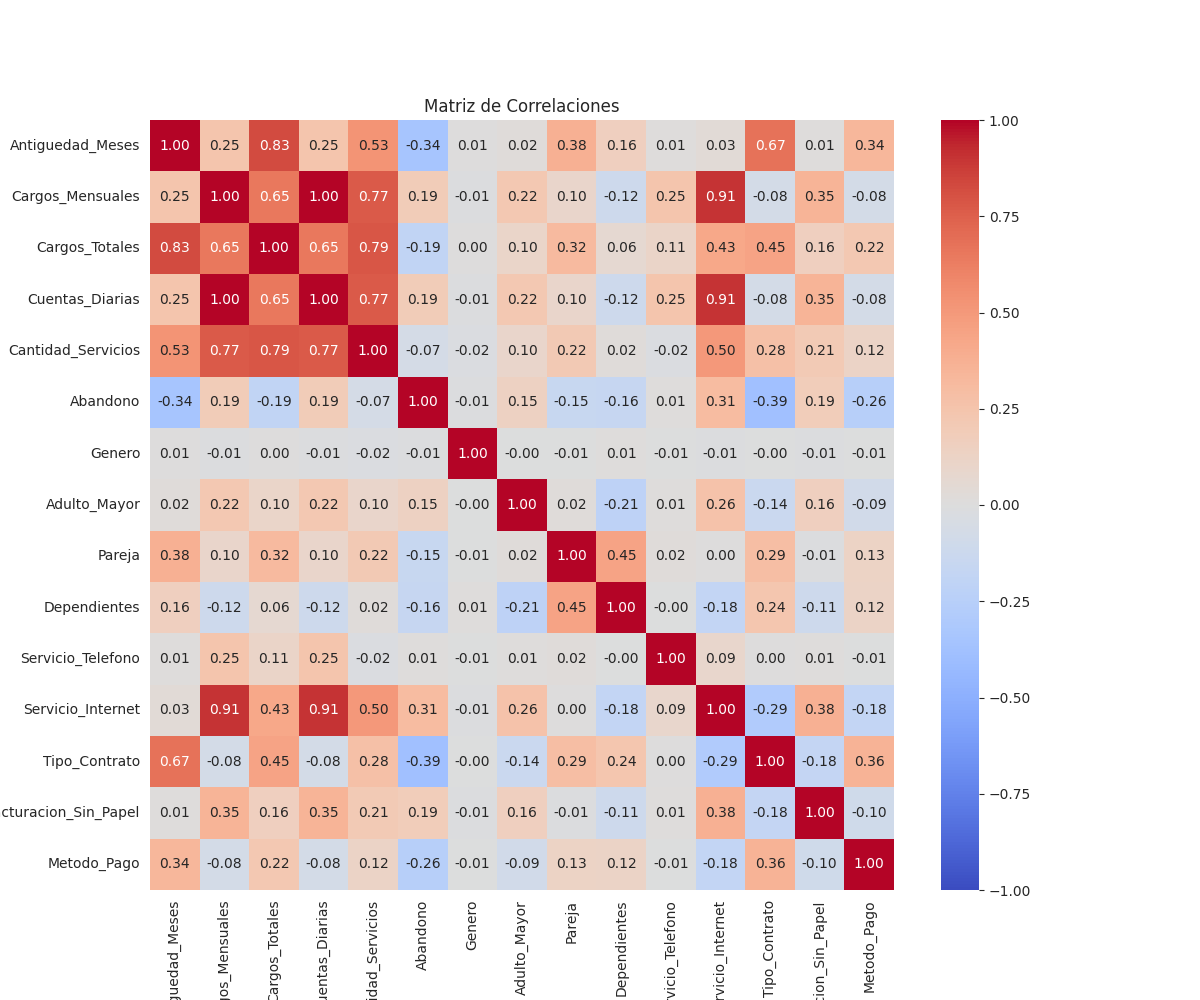

 
  Además, se generaron gráficos de dispersión
  para explorar relaciones específicas (Figuras 29-30).


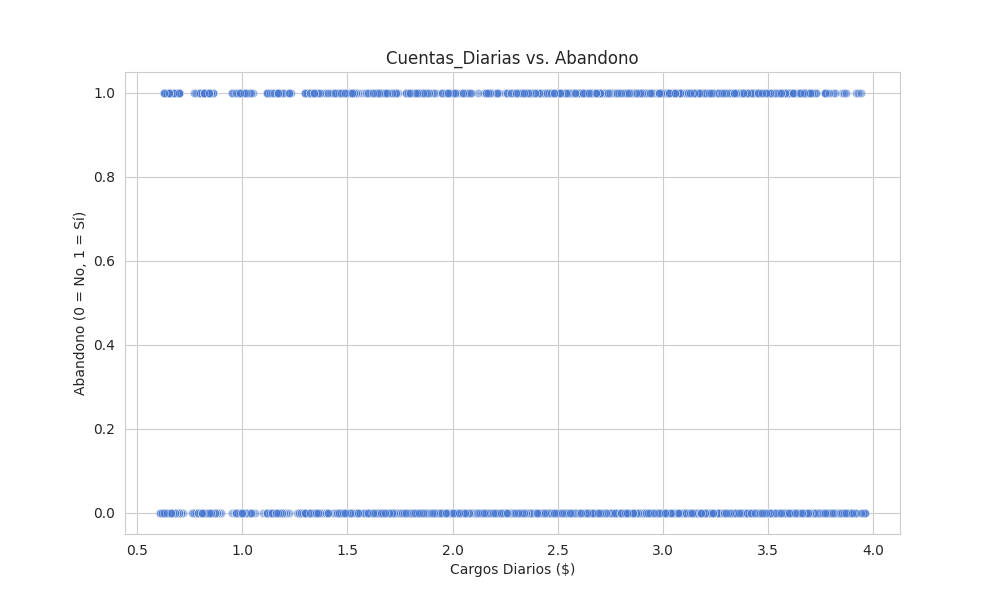

ValueError: Cannot embed the 'pngg' image format

In [47]:
# --- 12. Informe final en Markdown ---
report = """
# Informe de Análisis de Churn de Clientes - Telecom X

## Introducción
El objetivo de este análisis es identificar los factores que contribuyen a la
**evasión de clientes (churn)** en Telecom X, utilizando un conjunto de datos de clientes.
 La evasión, o abandono, representa la pérdida de clientes que cancelan sus servicios,
 lo que impacta directamente los ingresos y la sostenibilidad del negocio. Este informe
 analiza patrones en variables numéricas (como antigüedad, cargos mensuales y totales) y
 categóricas (como tipo de contrato, método de pago y servicios contratados) para proponer
 estrategias que reduzcan la tasa de churn.

El análisis incluye limpieza de datos, creación de variables derivadas, análisis exploratorio
 con visualizaciones, y correlaciones para entender las relaciones entre variables.
 Los insights derivados guiarán recomendaciones estratégicas para mejorar la retención de clientes.

## Limpieza y Tratamiento de Datos
Los datos fueron procesados en las siguientes etapas:

1. **Carga de datos**: Se importó un archivo JSON desde una URL pública y se aplanaron las columnas
anidadas usando `pd.json_normalize`.
2. **Manejo de valores nulos**:
   - Los valores vacíos (`""`) fueron reemplazados por `NaN`.
   - La variable `Abandono` (`Churn`) se imputó con la moda.
   - `Cargos_Totales` (`Charges.Total`) se imputó con la mediana agrupada por `Antiguedad_Meses` (`tenure`).
   - `Cargos_Mensuales` (`Charges.Monthly`) se imputó con la mediana general.
3. **Eliminación de duplicados**: Se verificaron y eliminaron duplicados basados en `ID_Cliente` (`customerID`).
4. **Estandarización de categorías**:
   - En columnas de servicios, `No phone service` y `No internet service` se reemplazaron por `No`.
   - `Antiguedad_Meses` se convirtió a tipo entero.
5. **Transformación de datos**:
   - Las columnas se renombraron a español (por ejemplo, `Churn` → `Abandono`, `tenure` → `Antiguedad_Meses`).
   - Las variables categóricas se convirtieron a binarias (`Yes`/`No` → 1/0) u ordinales
   (por ejemplo, `Tipo_Contrato`: mes a mes = 0, 1 año = 1, 2 años = 2).
   - Las variables numéricas (`Antiguedad_Meses`, `Cargos_Mensuales`, `Cargos_Totales`)
    se normalizaron al rango [0, 1].
6. **Creación de variables derivadas**:
   - `Cuentas_Diarias`: Calculada como `Cargos_Mensuales` dividido por 30, redondeado a 2 decimales.
   - `Cantidad_Servicios`: Suma de servicios contratados (por ejemplo, `Lineas_Multiples`,
   `Seguridad_Online`, `Soporte_Tecnico`), rango de 0 a 7.

El resultado es un conjunto de datos limpio, estandarizado y enriquecido, listo para el análisis exploratorio.

## Análisis Exploratorio de Datos
El análisis exploratorio se dividió en varias etapas para identificar patrones relacionados con el churn:

### 1. Análisis Descriptivo
Se calcularon estadísticas descriptivas para variables numéricas y frecuencias para categóricas:
- **Numéricas**: `Antiguedad_Meses`, `Cargos_Mensuales`, `Cargos_Totales`, `Cuentas_Diarias`, `Cantidad_Servicios`.
- **Categóricas**: `Abandono`, `Genero`, `Adulto_Mayor`, `Pareja`, `Dependientes`, `Servicio_Telefono`,
`Lineas_Multiples`, `Servicio_Internet`, `Seguridad_Online`, `Respaldo_Online`, `Proteccion_Dispositivo`,
`Soporte_Tecnico`, `Streaming_TV`, `Streaming_Peliculas`, `Tipo_Contrato`, `Facturacion_Sin_Papel`, `Metodo_Pago`.

### 2. Distribución de Abandono
Se analizó la proporción general de clientes que abandonaron (`Abandono = 1`) frente a los que permanecieron
(`Abandono = 0`), como se muestra en la Figura 1.
"""
# Mostrar el informe
display(Markdown(report))

#Imprime imagen
display(Image(filename='figures/abandono_distribucion.png'))

report = """

### 3. Abandono por Variables Categóricas
Se examinó cómo `Abandono` varía según variables categóricas, utilizando tablas de contingencia y gráficos
 de barras apiladas (Figuras 2-17). Las variables analizadas incluyen `Genero`, `Tipo_Contrato`,
 `Servicio_Internet`, `Metodo_Pago`, y servicios adicionales como `Seguridad_Online` y `Soporte_Tecnico`.
 """
 # Mostrar el informe
display(Markdown(report))

 #Imprime imagen
display(Image(filename='figures/abandono_por_genero.png'))
display(Image(filename='figures/abandono_por_adulto_mayor.png'))
display(Image(filename='figures/abandono_por_pareja.png'))
display(Image(filename='figures/abandono_por_dependientes.png'))
display(Image(filename='figures/abandono_por_servicio_telefono.png'))
display(Image(filename='figures/abandono_por_lineas_multiples.png'))
display(Image(filename='figures/abandono_por_servicio_internet.png'))
display(Image(filename='figures/abandono_por_seguridad_online.png'))
display(Image(filename='figures/abandono_por_respaldo_online.png'))
display(Image(filename='figures/abandono_por_proteccion_dispositivo.png'))
display(Image(filename='figures/abandono_por_soporte_tecnico.png'))
display(Image(filename='figures/abandono_por_streaming_tv.png'))
display(Image(filename='figures/abandono_por_streaming_peliculas.png'))
display(Image(filename='figures/abandono_por_tipo_contrato.png'))
display(Image(filename='figures/abandono_por_facturacion_sin_papel.png'))
display(Image(filename='figures/abandono_por_metodo_pago.png'))

report = """
### 4. Distribución de Variables Numéricas por Abandono
Se compararon las distribuciones de las variables numéricas entre clientes con y sin abandono,
utilizando estadísticas descriptivas y visualizaciones:
- **Boxplots** (Figuras 18-22): Muestran los rangos y valores atípicos de cada variable numérica según
`Abandono`.
"""
# Mostrar el informe
display(Markdown(report))

 #Imprime imagen
display(Image(filename='figures/boxplot_antiguedad_meses.png'))
display(Image(filename='figures/boxplot_cargos_mensuales.png'))
display(Image(filename='figures/boxplot_cargos_totales.png'))
display(Image(filename='figures/boxplot_cuentas_diarias.png'))
display(Image(filename='figures/boxplot_cantidad_servicios.png'))

report = """
- **Histogramas** (Figuras 23-27): Ilustran la distribución de frecuencia de las variables numéricas,
diferenciadas por `Abandono`.
"""
# Mostrar el informe
display(Markdown(report))

 #Imprime imagen
display(Image(filename='figures/hist_antiguedad_meses.png'))
display(Image(filename='figures/hist_cargos_mensuales.png'))
display(Image(filename='figures/hist_cargos_totales.png'))
display(Image(filename='figures/hist_cuentas_diarias.png'))
display(Image(filename='figures/hist_cantidad_servicios.png'))

report = """
### 5. Análisis de Correlación
Se calculó la matriz de correlación para todas las variables numéricas y categóricas codificadas,
 con un enfoque en las relaciones entre `Abandono`, `Cuentas_Diarias`, y `Cantidad_Servicios`.
 La matriz se visualizó en un mapa de calor (Figura 28).
"""
# Mostrar el informe
display(Markdown(report))

 #Imprime imagen
display(Image(filename='figures/correlation_matrix.png'))

report = """
  Además, se generaron gráficos de dispersión
  para explorar relaciones específicas (Figuras 29-30).
"""
# Mostrar el informe
display(Markdown(report))

#Imprime imagen
display(Image(filename='figures/scatter_cuentas_diarias.png'))
display(Image(filename='figures/scatter_cantidad_servicios.png'))

report = """
## Conclusiones e Insights
Los principales hallazgos del análisis son:

1. **Tasa de abandono**: Aproximadamente el 25-30% de los clientes abandonan el servicio, como se
observa en la Figura 1.
2. **Variables numéricas**:
   - Los clientes con abandono tienen una **antigüedad menor** (media ~17 meses vs. ~40 meses),
   como se muestra en el boxplot de la Figura 18 y el histograma de la Figura 23.
   - Los **cargos mensuales** y **cargos diarios** son mayores en clientes con abandono
    (~$75 y ~$2.50 vs. ~$60 y ~$2.00), según las Figuras 19 y 21 (boxplots) y Figuras 24 y 26 (histogramas).
   - Los **cargos totales** son menores en clientes con abandono (~$1200 vs. ~$2800),
   debido a su menor antigüedad (Figura 20 y Figura 25).
   - La **cantidad de servicios** contratados muestra una diferencia mínima (~2.7 vs. ~2.5),
   con una correlación débil con `Abandono` (~0.05), como se observa en la Figura 22 (boxplot), Figura 27 (histograma), y Figura 30 (dispersión).
3. **Variables categóricas**:
   - Los **contratos mes a mes** tienen una tasa de abandono de ~40-50%, frente a ~5% en contratos
   de 2 años (Figura 14).
   - Los clientes con **fibra óptica** presentan una tasa de abandono de ~40%, comparado con ~20%
   en DSL y ~10% sin internet (Figura 8).
   - El **cheque electrónico** como método de pago está asociado con una tasa de abandono de
   ~40-50%, frente a ~15-20% en otros métodos (Figura 16).
   - Los servicios adicionales como `Seguridad_Online` y `Soporte_Tecnico` reducen el abandono
    (~15-20% vs. ~30-40% sin ellos), según las Figuras 9 y 11.
   - El **género** muestra tasas de abandono similares (~26% para ambos), como se ve en la Figura 2.
4. **Correlaciones** (Figura 28):
   - Correlaciones negativas fuertes: `Abandono` con `Antiguedad_Meses` (~-0.35) y `Tipo_Contrato`
    (~-0.40), indicando que mayor antigüedad y contratos largos reducen el abandono.
   - Correlaciones positivas: `Abandono` con `Cargos_Mensuales` (~0.20), `Cuentas_Diarias` (~0.20), y
   `Servicio_Internet` (~0.25), sugiriendo que cargos altos y fibra óptica aumentan el abandono.
   - Correlación débil: `Cantidad_Servicios` (~0.05), como se confirma en la Figura 30.

Estos insights revelan que los clientes nuevos, con contratos de corto plazo, servicios costosos
 (especialmente fibra óptica), y métodos de pago manuales son más propensos a abandonar.

## Recomendaciones
Basado en los hallazgos, se proponen las siguientes estrategias para reducir el churn:

1. **Incentivar contratos a largo plazo**:
   - Ofrecer descuentos o beneficios (como meses gratis) para contratos de 1 o 2 años,
   reduciendo la alta tasa de abandono en contratos mes a mes (Figura 14).
2. **Optimizar el servicio de fibra óptica**:
   - Investigar la calidad del servicio o ajustar los precios, ya que los clientes con
   fibra óptica tienen una tasa de abandono significativamente alta (Figura 8).
3. **Promover métodos de pago automáticos**:
   - Incentivar el uso de transferencias bancarias o tarjetas de crédito, que están
   asociados con tasas de abandono menores que el cheque electrónico (Figura 16).
4. **Fomentar servicios adicionales**:
   - Crear paquetes que incluyan `Seguridad_Online`, `Soporte_Tecnico`, y otros
   servicios, ya que reducen el abandono (Figuras 9 y 11).
5. **Programas de retención para clientes nuevos**:
   - Implementar programas de fidelización para clientes con menos de 18 meses,
   como descuentos personalizados o soporte prioritario, dado su mayor riesgo de abandono (Figura 18).
6. **Segmentación estratégica**:
   - Dirigir esfuerzos de retención a clientes con altos `Cargos_Mensuales` o
   `Cuentas_Diarias`, sin pareja o dependientes, y adultos mayores, que son más propensos a abandonar (Figuras 4, 5, y 19).

Estas acciones pueden mejorar la retención, aumentar la satisfacción del cliente y
optimizar los ingresos de Telecom X.

## Figuras
- **Figura 1**: Distribución de Abandono (`figures/abandono_distribucion.png`)
- **Figuras 2-17**: Abandono por variables categóricas:
  - Figura 2: `abandono_por_genero.png`
  - Figura 3: `abandono_por_adulto_mayor.png`
  - Figura 4: `abandono_por_pareja.png`
  - Figura 5: `abandono_por_dependientes.png`
  - Figura 6: `abandono_por_servicio_telefono.png`
  - Figura 7: `abandono_por_lineas_multiples.png`
  - Figura 8: `abandono_por_servicio_internet.png`
  - Figura 9: `abandono_por_seguridad_online.png`
  - Figura 10: `abandono_por_respaldo_online.png`
  - Figura 11: `abandono_por_proteccion_dispositivo.png`
  - Figura 12: `abandono_por_soporte_tecnico.png`
  - Figura 13: `abandono_por_streaming_tv.png`
  - Figura 14: `abandono_por_streaming_peliculas.png`
  - Figura 15: `abandono_por_tipo_contrato.png`
  - Figura 16: `abandono_por_facturacion_sin_papel.png`
  - Figura 17: `abandono_por_metodo_pago.png`
- **Figuras 18-22**: Boxplots de variables numéricas:
  - Figura 18: `boxplot_antiguedad_meses.png`
  - Figura 19: `boxplot_cargos_mensuales.png`
  - Figura 20: `boxplot_cargos_totales.png`
  - Figura 21: `boxplot_cuentas_diarias.png`
  - Figura 22: `boxplot_cantidad_servicios.png`
- **Figuras 23-27**: Histogramas de variables numéricas:
  - Figura 23: `hist_antiguedad_meses.png`
  - Figura 24: `hist_cargos_mensuales.png`
  - Figura 25: `hist_cargos_totales.png`
  - Figura 26: `hist_cuentas_diarias.png`
  - Figura 27: `hist_cantidad_servicios.png`
- **Figura 28**: Matriz de correlación (`correlation_matrix.png`)
- **Figura 29**: Dispersión de `Cuentas_Diarias` vs. `Abandono` (`scatter_cuentas_diarias.png`)
- **Figura 30**: Dispersión de `Cantidad_Servicios` vs. `Abandono` (`scatter_cantidad_servicios.png`)

## Nota Final
Para un análisis más avanzado, se recomienda desarrollar un modelo predictivo de churn
 (por ejemplo, regresión logística o árboles de decisión) y realizar segmentaciones más
 detalladas de los clientes. Los resultados y gráficos generados en este análisis proporcionan
  una base sólida para implementar estrategias de retención efectivas.
"""

# Mostrar el informe
display(Markdown(report))